In [1]:
from IPython.display import HTML

HTML('''<script>
code_hide=false; 
function code_toggle() {
 if (code_hide){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_hide = !code_hide
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clickear acá para mostrar/ocultar código."></form>''')

In [ ]:
# SOLO PARA CORRER EN COLAB DDE GH
!git clone https://github.com/tvillani22/PSeI.git # Master
import sys
import os
sys.path.append('/content/PSeI/')
os.chdir('PSeI/')

In [2]:
import numpy as np
import scipy.fft as fft
import scipy.signal as ss
import scipy.ndimage as si
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tck
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
import PIL.Image
from IPython import display
mpl.rcParams['axes.titlesize']=13

***
<h1 style="color:black;font-size:40px"><center>MÓDULO 5</center></h1>

***
***

# 5.3 Actividad 13

***
>***Implementar y aplicar filtros en el dominio frecuencial (pasabajos y pasaaltos; ideal, gaussiano y butterworth).<br> 
Si querés, podrías generar una función de Matlab que tenga por argumento: Imagen y frecuencia de corte y devuelva las seis imágenes filtradas (u otra variante que consideres más adecuada).***
***

***Abro la imagen, calculo su transformada y visualizo en espacio y en frecuencia (log)...***

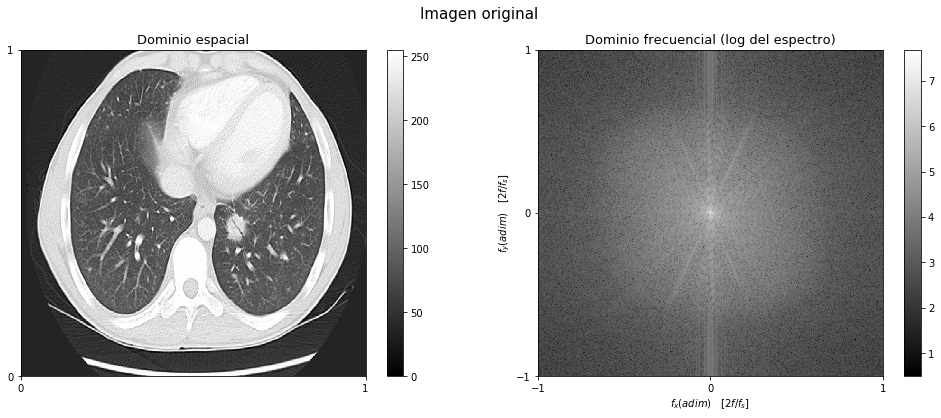

In [3]:
img = mpl.image.imread('Data/Torax.bmp')
img = np.delete(img,(-1), axis=0)
M, N = img.shape

mi_fft = lambda f: fft.fftshift(fft.fft2(f))
F = mi_fft(img)
axis_f = {'xticks': range(-1,2), 'yticks': range(-1,2),
          'xlabel':'$f_x(adim)$   $[2f/f_s]$', 'ylabel':'$f_y(adim)$   $[2f/f_s]$'}    # paráms ejes plot frecuencia

def visualizar(imgs,tit,vmax=None):
    fig, ax = plt.subplots(1, 2, figsize=(17,6))
    fig.suptitle(tit, fontsize=15)
    subs = ['Dominio espacial', 'Dominio frecuencial (log del espectro)']
    extents = [[0, 1, 0, 1], [-1, 1, -1, 1]]    
    customs = [{'xticks':[0,1], 'yticks':[0,1]}, axis_f]
    #extents = [[0, M, 0, N], [-1, 1, -1, 1]]
    #customs = [{'xticks':[0,M], 'yticks':[0,N]}, axis_f]
    for axx, img, extent, sub, cust in zip(ax, [imgs[0], np.log10(abs(imgs[1]) + 1)], extents, subs, customs):
        cb = axx.imshow(img, cmap='gray', vmax=vmax, aspect='auto', extent=extent)
        axx.set_title(sub)
        fig.colorbar(cb, ax=axx)
        fig.subplots_adjust(top=0.88)
        axx.set(**cust)
    return

visualizar([img, F], 'Imagen original')

***
## Filtros pasabajos

***Uso la normalización de frecuencias en unidades de $\frac{2f}{f_s}$, para armar el dominio de frecuencias como un cuadrado de lado 2 en el que se inscriba una circunferencia de radio 1. En ese dominio armo la respuesta en frecuencia de los filtros y la visualizo...***

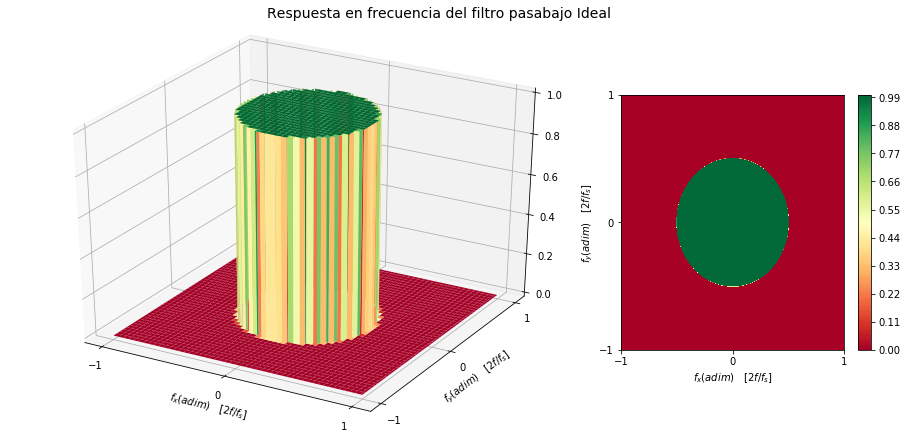

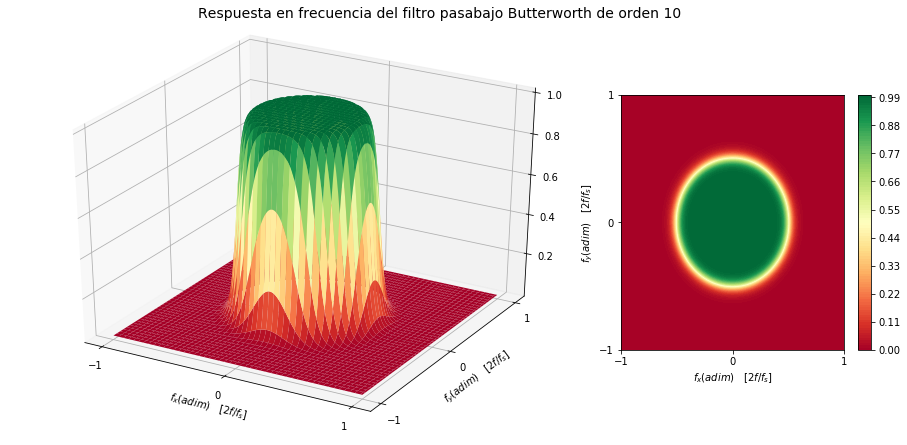

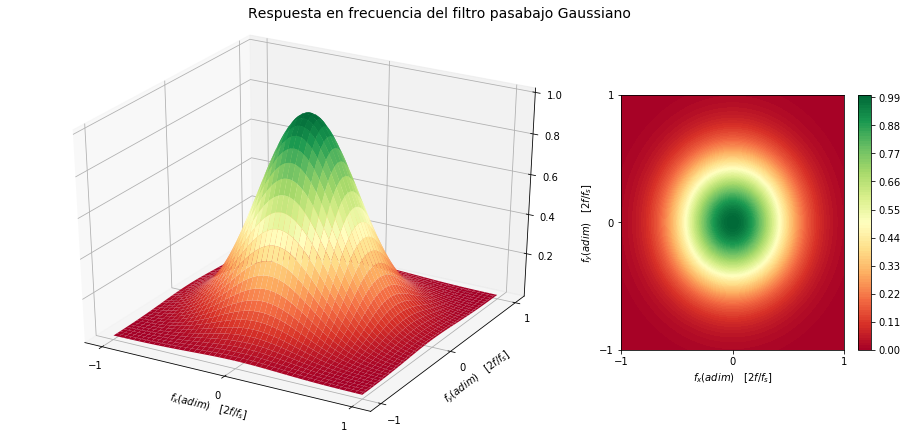

In [4]:
# Dominio de frecuencias
stepfx = 2/N
stepfy = 2/M
wx, wy = np.meshgrid(np.arange(-1+stepfx/2, 1+stepfx/2, stepfx), np.arange(-1+stepfy/2, 1+stepfy/2,stepfy))

# ARMO LOS FILTROS
# Parámetros comunes..
D = (wx**2 + wy**2)**(1/2)   # matriz de "distancias"
D0 = 0.5                     # frecuencia de corte (en unidades de fs/2)

# Filtro ideal
ILPF = np.ones_like(D)
ILPF[D>D0] = 0

# Filtro Butterworth
n = 10                        # orden
BLPF = (1 + (D/D0)**(2*n))**(-1)

# Filtro Gaussiano
GLPF = np.exp(-D**2/D0**2)

# Armo función para visualizar funciones de transferencia de filtros
def visualizar_filtro(H, tit):
    grid = plt.GridSpec(5, 3, wspace=0.1, hspace=0.1)
    cmap = 'RdYlGn'
    fig = plt.figure(figsize=(16,7))
    fig.suptitle('Respuesta en frecuencia del filtro '+tit, fontsize=14)
    fig.subplots_adjust(top=0.98)
    ax = fig.add_subplot(grid[:,0:2], projection='3d')
    ax.plot_surface(wx, wy, H, cmap=cmap, edgecolor='none')
    ax.set(**axis_f)
    ax = fig.add_subplot(grid[1:4,2:])
    cb = ax.contourf(wx, wy, H, 100, cmap=cmap)
    ax.set(**axis_f)
    fig.colorbar(cb, ax=ax)
    return

# Visualizo las 3 rtas en frecuencia..
filtros_pb = [ILPF, BLPF, GLPF]
nombres = ['Ideal', 'Butterworth de orden {}'.format(n), 'Gaussiano']
for filtro, nombre in zip(filtros_pb, nombres):
    visualizar_filtro(filtro, 'pasabajo ' + nombre)

***Hago el producto elemento a elemento con la transfromada centrada de la imagen, vuelvo al domino espacial y visualizo...***

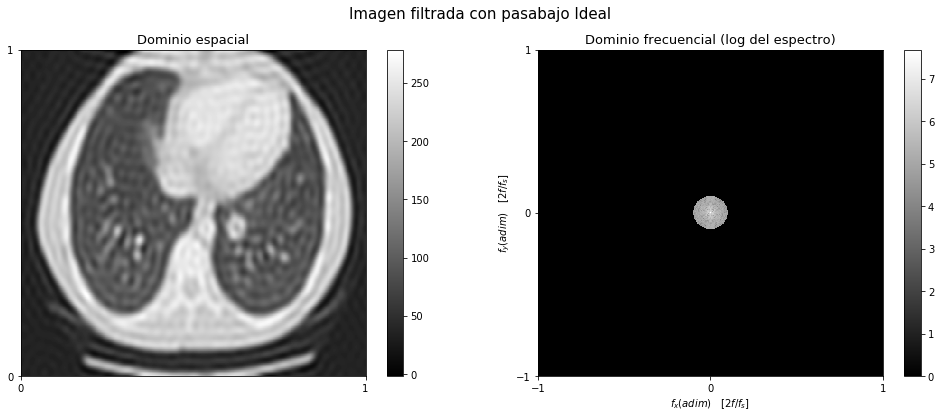

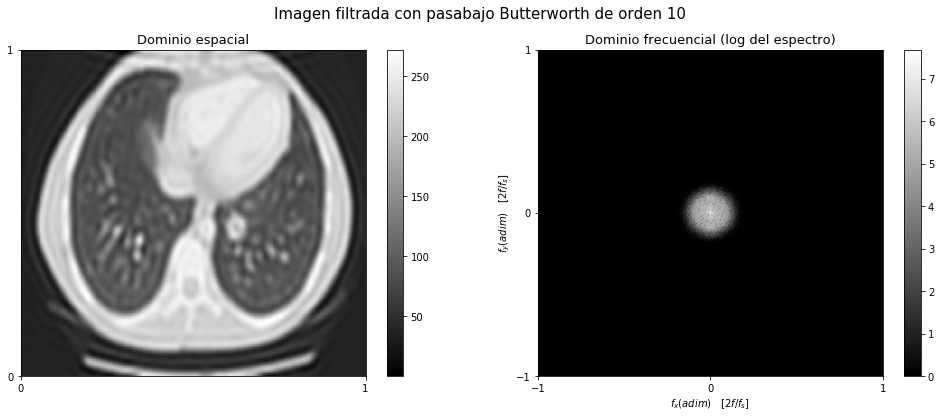

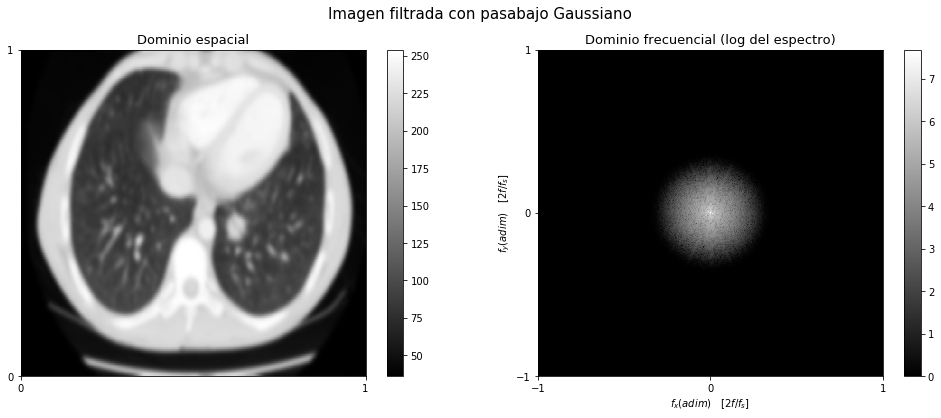

In [5]:
# Defino los filtros con una frecuencia de corte
# más restrictiva para observar mejor el efecto...
D0 = 0.1
ILPF_ = np.ones_like(D)
ILPF_[D>D0] = 0
BLPF_ = (1 + (D/D0)**(2*n))**(-1)
GLPF_ = np.exp(-D**2/D0**2)
filtros_pb_ = [ILPF_, BLPF_, GLPF_]

# Aplico filtrado...
for filtro, nombre in zip(filtros_pb_, nombres):
    G = F*filtro                             # producto en frecuencia
    g =  fft.ifft2(fft.ifftshift(G)).real    # descentro, antitransformo y me quedo con la parte real
    visualizar([g, G],'Imagen filtrada con ' # visualizo        
               'pasabajo ' + nombre)  

***Puede observarse el efecto se "blurring" en las tres transformaciones, similar al que se conseguía filtrando en el dominio espacial con kernel suavizantes. A su vez puede notarse un claro fenómeno de "ringing" en el filtro ideal, y en en menor medida en el Butterworth (aunque notorio porque se trata de un orden 10). Por el contrario, el efecto del filtro gaussiano es más suave y no produce artefactos.***

***
## Filtros pasaaltos

***Usando el dominio de Fourier ya creado, y los pasabajos armados, creo los correspondientes pasaaltos como su complemento, con:***

$$
H_{HP} = 1 - H_{LP}
$$

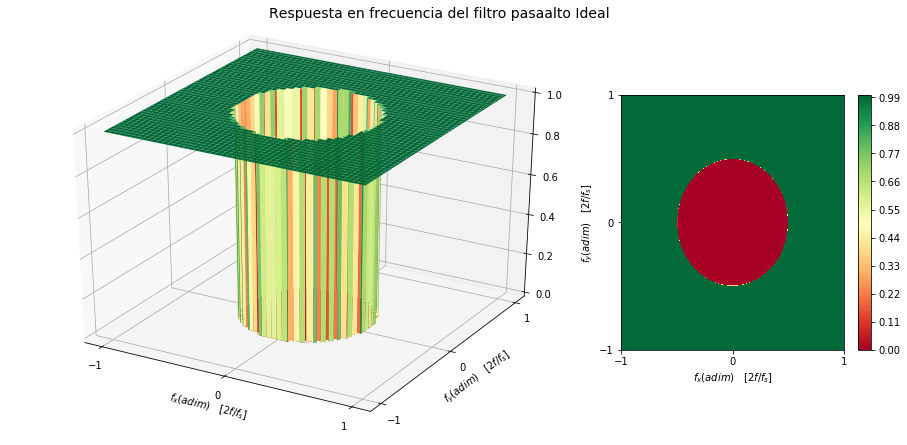

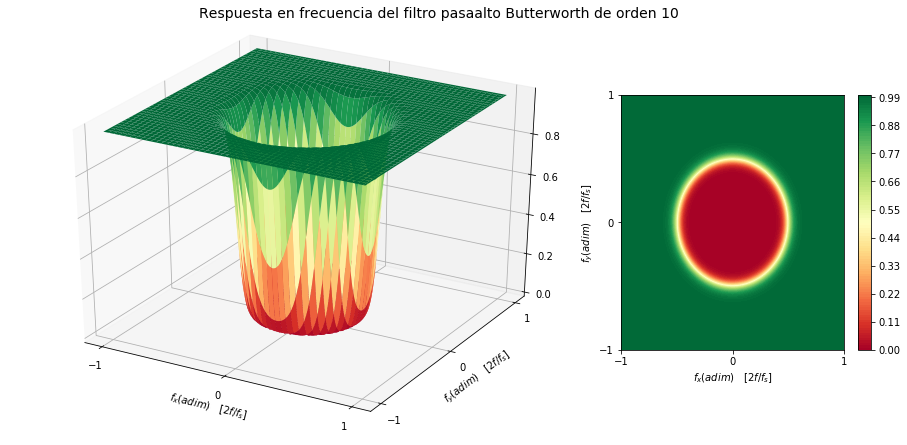

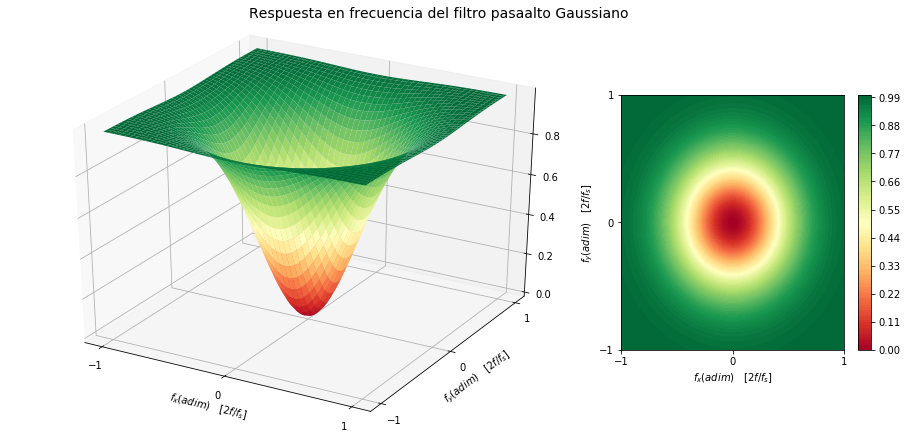

In [6]:
filtros_pa = [1 - filtro for filtro in filtros_pb]

# Visualizo las 3 rtas en frecuencia..
nombres = ['Ideal', 'Butterworth de orden {}'.format(n), 'Gaussiano']
for filtro, nombre in zip(filtros_pa, nombres):
    visualizar_filtro(filtro, 'pasaalto ' + nombre)

***Hago el producto elemento a elemento con la transfromada centrada de la imagen, vuelvo al domino espacial y visualizo...***

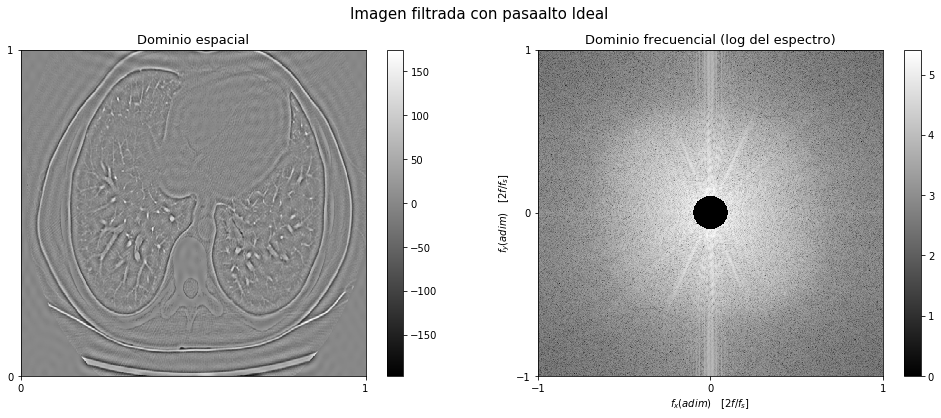

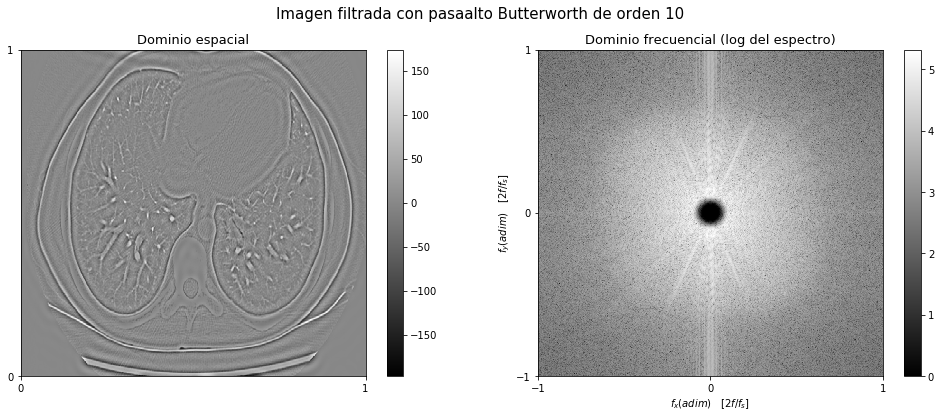

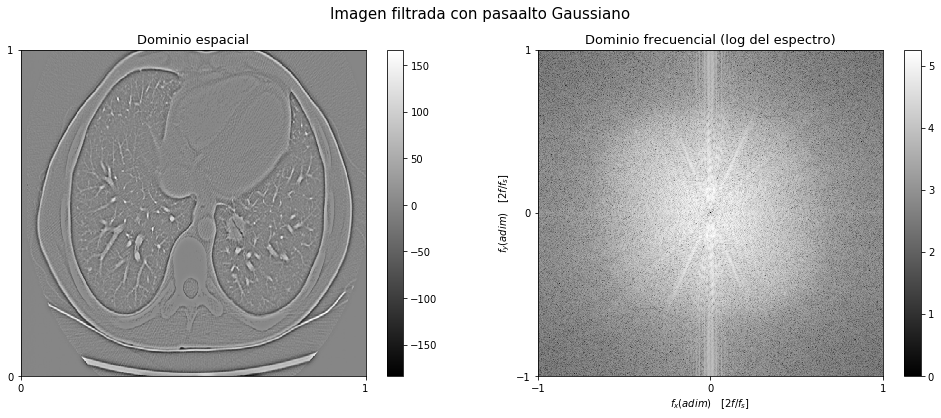

In [7]:
# Uso el complemento de los filtros con frecuecia de corte más restrictiva..
filtros_pa_ = [1 - filtro for filtro in filtros_pb_]

# Aplico filtrado...
for filtro, nombre in zip(filtros_pa_, nombres):
    G = F*filtro                             # producto en frecuencia
    g =  fft.ifft2(fft.ifftshift(G)).real    # descentro, antitransformo y me quedo c/real
    visualizar([g, G],'Imagen filtrada con ' # visualizo        
               'pasaalto ' + nombre)  

***En este caso puede observarse cómo los filtros que dejan pasar la banda de altas frecuencias crean una máscara con los bordes y las transiciones abruptas de la imagen, similar a la que se conseguía filtrando en espacio con el kernel laplaciano. Como en el módulo anterior, combinando esta imagen con la original puede obtenerse una imagen con bordes realzados.<br>
A su vez, nótese que también aparece el fenómento de "ringing", de forma evidente para el filtro Ideal, algo menos para el Butterworth (orden 10), y ausente en el Gaussiano.***

***
## Función de filtrado

***Es posible armar una función que dada una imagen, una frecuencia de corte y un tipo de filtro, devuelva la imagen filtrada en dominio espacial y su espectro...***

In [10]:
def filtrado(img, fc=0.3, banda_p='B', filtro='G', n=2, plot=True):
    '''
    Función que aplica filtrado en frecuencia.
    Devuelve imagen filtrada en dominio espacial.
    Parámetros:
    -----------
    img:    array 2D.
            La imagen a filtrar.
    fc:     float ϵ[0,1], opcional.
            Frecuencia de corte en unidades de la mitad
            de la frecuencia de muestreo.
    banda_p:{'B', 'A'}, opcional.
            Banda pasante: 'L' = baja; 'H' = alta.
    filtro: {'I', 'B', 'G'}, opcional.
            Tipo de filtro: 'I' = ideal,'B' = Butterworth, 'G' = gaussiano.
    n:      int>0, opcional.
            Orden de filtro en caso de filtro = Butterworth.
    plot:   Bool, opcional.
            Opción de mostrar la imagen transformada y su espectro.
    '''
    
    assert (filtro in ['I', 'B', 'G'] and 
            banda_p in ['L', 'H'] and 
            (fc <=np.sqrt(2) and fc >= 0)),'Parámetro incorrecto'
    
    funcion = {'I': lambda D,fc,n: np.where(D>fc, 0, 1),
               'B': lambda D,fc,n: (1 + (D/fc)**(2*n))**(-1),
               'G': lambda D,fc,n: np.exp(-D**2/fc**2)}
    filtros_n = {'I': 'Ideal', 'B': 'Butterworth de orden {}'.format(n),
                 'G': 'Gaussiano', 'L': 'bajo', 'H': 'alto'}
    
    stepfy, stepfx = 2/img.shape[0], 2/img.shape[1]
    wx, wy = np.meshgrid(np.arange(-1+stepfx/2, 1+stepfx/2, stepfx),
                         np.arange(-1+stepfy/2, 1+stepfy/2,stepfy))
    F = fft.fftshift(fft.fft2(img))
    D = (wx**2 + wy**2)**(1/2)
    H = funcion[filtro](D,fc,n)
    if banda_p == 'H': H = 1 - H
    G = F*H 
    img_f = fft.ifft2(fft.ifftshift(G)).real
    if plot:
        visualizar([img_f, G],'Imagen filtrada con pasa{} de tipo {} - frecuencia de corte {}$f_s$'
                   .format(filtros_n[banda_p], filtros_n[filtro], fc/2))
    return img_f

***Probando algunos ejemplos...***

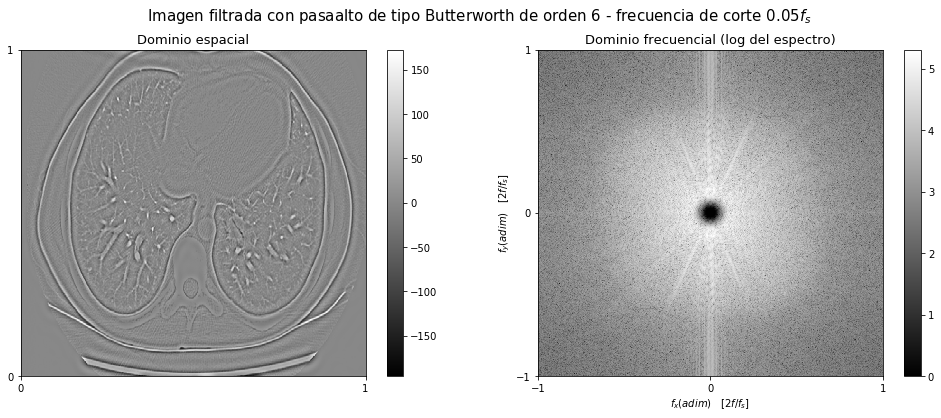

In [11]:
filtrado(img, fc=0.1, banda_p='H', filtro='B', n=6);

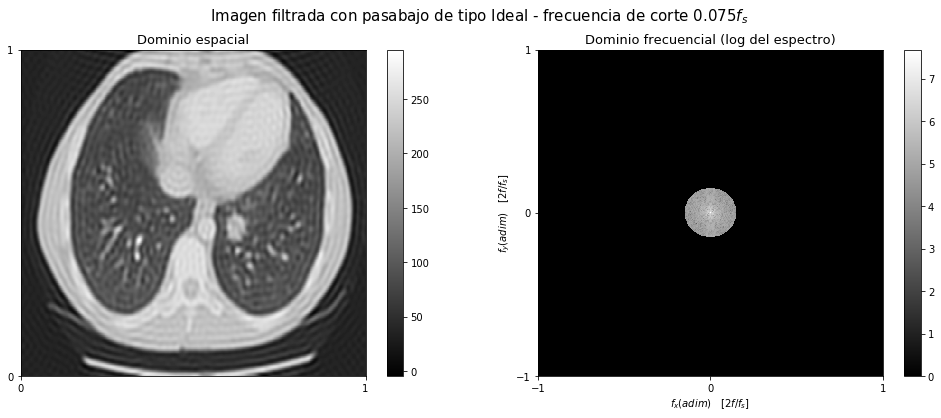

In [12]:
filtrado(img, fc=0.15, banda_p='L', filtro='I');

***Y con otras imágenes usadas previamente...***

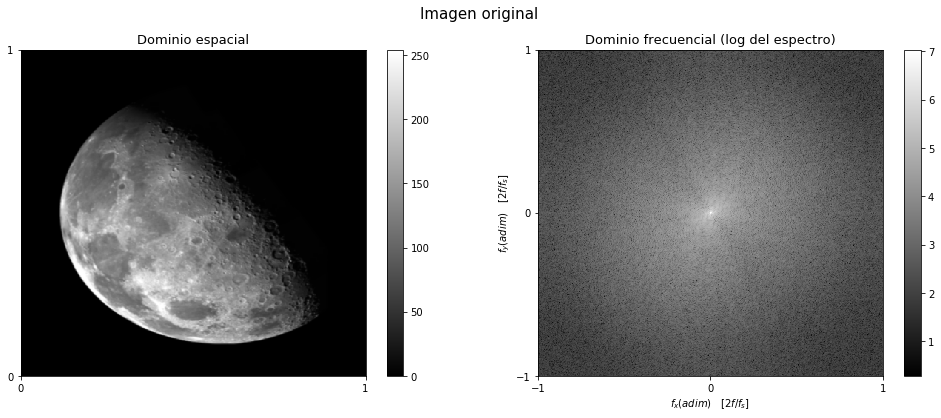

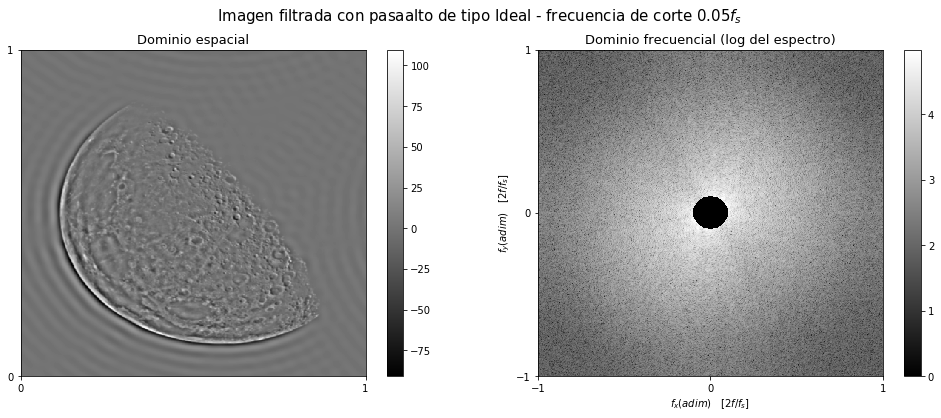

In [13]:
moon = mpl.image.imread('Data/blurry_moon.tif')
visualizar([moon, mi_fft(moon)], 'Imagen original')
filtrado(moon, fc=0.1, banda_p='H', filtro='I');

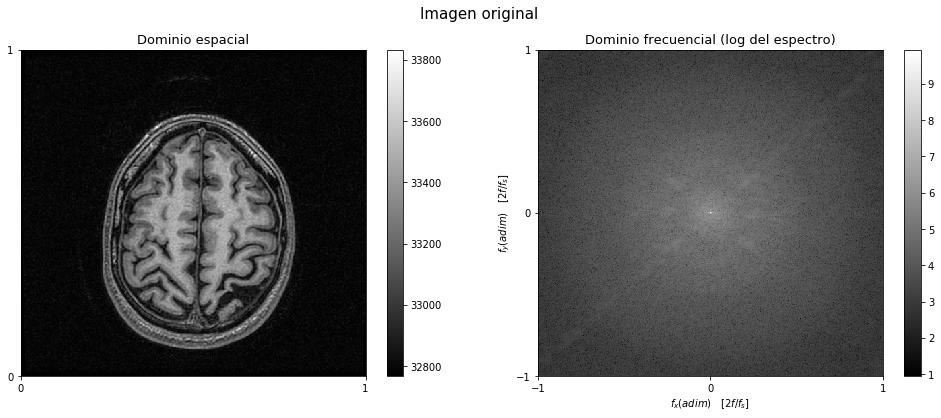

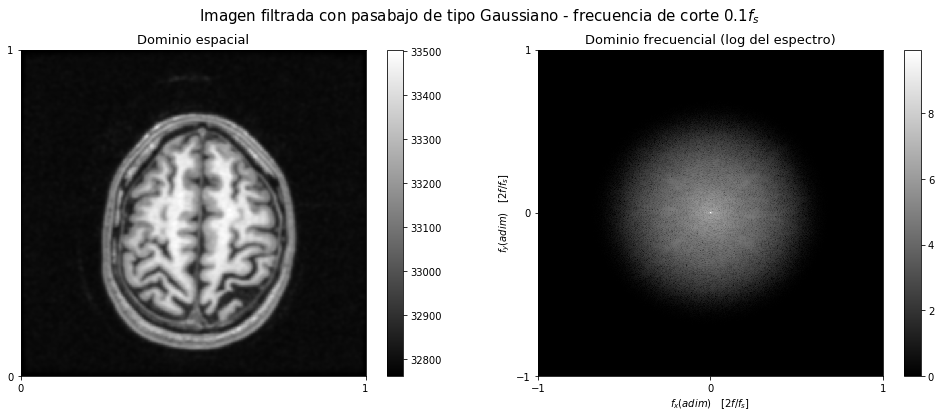

In [14]:
cerebro = mpl.image.imread('Data/cerebro.tif')
visualizar([cerebro, mi_fft(cerebro)], 'Imagen original')
filtrado(cerebro, fc=0.2, banda_p='L', filtro='G');

***
***

# 5.3 Actividad 14

***
>***Explorá la correspondencia entre el dominio frecuencial y el dominio espacial de los filtros.
Para eso, partí de los filtros en el dominio espacial h, generá la función de respuesta en el dominio frecuencial H, y compará el resultado del filtrado en ambos dominios.***
***

***Primero creo una función para obtener la respuesta en frecuencia a partir del kernel del filtro en el dominio espacial...***

In [15]:
def rta_frec(h, img):
    h_r, h_c = h.shape
    H_r, H_c = img.shape
    pady, padx = (H_r - h_r)//2, (H_c - h_c)//2
    h_pad = np.pad(h, ((pady, pady), (padx, padx)), 'constant')   # filtro en dominio espacial centrado
    h_pad = fft.ifftshift(h_pad)                                  # descentrado
    H = mi_fft(h_pad)                                             # transformación y centrado (con función previa)
    return H

***Empezando por el filtro promediador como ejemplo de pasabajos...***

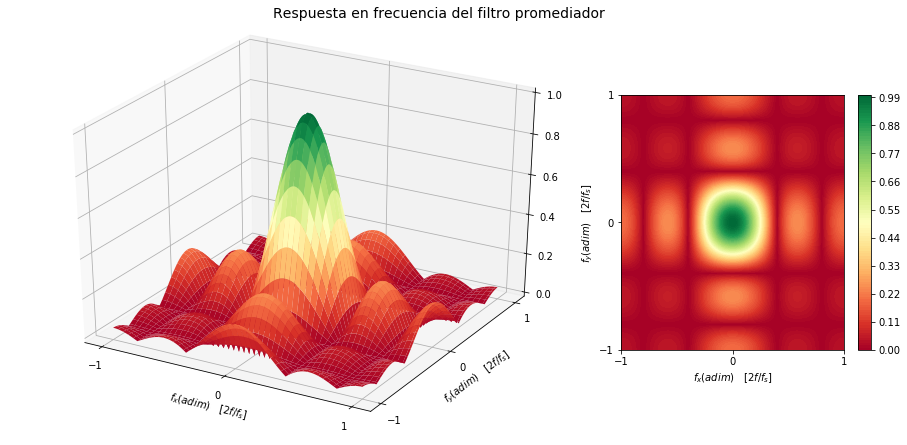

In [16]:
# Filtro suavizante...
L = 5 # dimensión del filtro
FS = np.ones((L,L))*1/L**2

# Obtengo rta en frecuencia..
FS_f = rta_frec(FS, img)

# Visualizo con la función creada para la actividad previa..
visualizar_filtro(abs(FS_f), 'promediador')

***Mirando la respuesta en frecuencia del filtro promediador, se explica el patrón de bandas nulas que se observaba en el espectro de la imagen resultante de aplicar ese filtro en el dominio espacial (Mód 4 - Actividad 11). El distanciado de ese patrón correlacionaba inversamente con el tamaño del kernel utilizado, que es lo mismo que ocurre aquí con la sinc2D y sus ceros.<br>
<br>
Comparo los filtrados...***

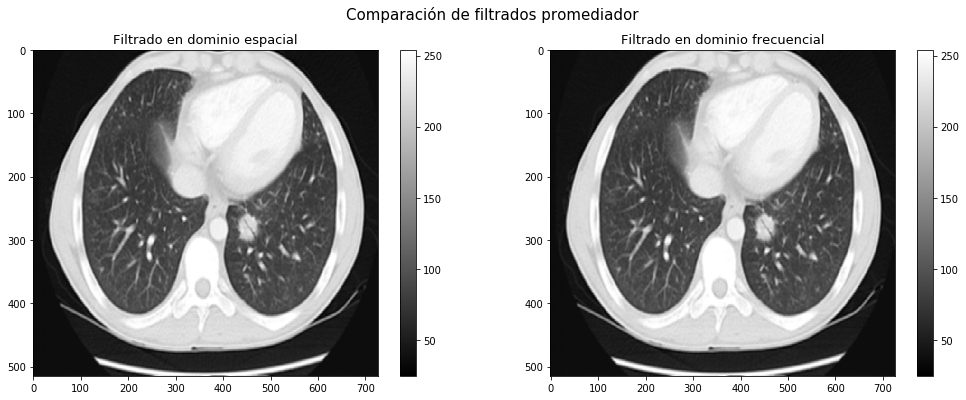

In [17]:
# Aplico filtrado en dominio espacial (CONVOLUCIÓN)
img_s = si.convolve(img.astype(np.float64), FS, mode='wrap');
#img_s = si.uniform_filter(img.astype(np.float64), L, mode='wrap') # periodizado en los bordes

# Aplico filtrado en dominio frecuencial (PRODUCTO)
F = mi_fft(img)
img_s2 = F*FS_f
img_s2 = fft.ifft2(fft.ifftshift(img_s2)).real

# Defino una función para visualizar ambos filtrados a la par..
def visualizar_filtrados(imgs, tit='Comparación de filtrados'):
    fig, ax = plt.subplots(1,2,figsize=(17,6))
    fig.suptitle(tit, fontsize=15)
    subs = ['Filtrado en dominio espacial', 'Filtrado en dominio frecuencial']
    for axx, img, sub in zip(ax, imgs, subs):
        cb = axx.imshow(img, cmap='gray', aspect='auto')
        axx.set_title(sub)
        fig.colorbar(cb, ax=axx)
    fig.subplots_adjust(top=0.88)
    return

visualizar_filtrados([img_s, img_s2], tit='Comparación de filtrados promediador')

***Como era de esperar se observa que se obtienen los mismos resultados, tanto filtrando en el dominio espacial como haciéndolo en el frecuencial.<br>
<br>
Y verificando numéricamente que las imágenes son iguales, y las diferencias solo por cuestiones de cálculo numérico...***

In [18]:
print('Salvo por diferencias numéricas, las imágenes son iguales: {}.\n(diferencia máxima: {:.2g})'
      .format(np.allclose(img_s, img_s2), abs(img_s-img_s2).max()))

Salvo por diferencias numéricas, las imágenes son iguales: True.
(diferencia máxima: 5.4e-13)


***
***Procediendo análogamente con el filtro laplaciano, como ejemplo de pasaaltos...***

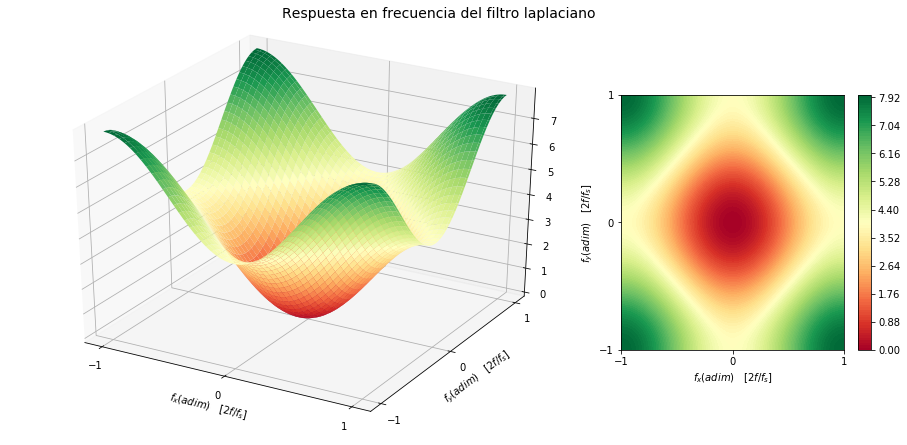

In [19]:
# Filtro laplaciano...
L = 3 # dimensión del filtro
FL = np.zeros((L,L))
FL[0,1], FL[1,0], FL[1,1], FL[1,2], FL[2,1] = 1, 1, -4, 1, 1 

# Obtengo rta en frecuencia..
FL_f = rta_frec(FL, img)

# Visualizo con la función creada para la actividad previa..
visualizar_filtro(abs(FL_f), 'laplaciano')

***Comparando el filtrado en ambos dominios...***

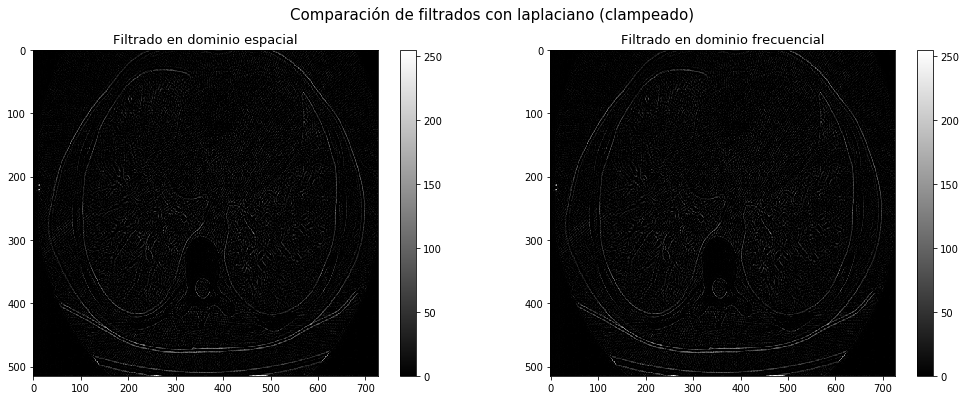

In [21]:
# Aplico filtrado en dominio espacial (CONVOLUCIÓN)
img_l = si.convolve(img.astype(np.float64), FL, mode='wrap')
#img_l = si.laplace(img.astype(np.float64), mode='wrap')

# Aplico filtrado en dominio frecuencial (PRODUCTO)
img_l2 = F*FL_f
img_l2 = fft.ifft2(fft.ifftshift(img_l2)).real


# Visualizo..
# Clampeo en los extremos
def clamp(img):
    img[img<0] = 0
    img[img>255] = 255
    return img
img_l = clamp(img_l)
img_l2 = clamp(img_l2)

visualizar_filtrados([img_l, img_l2], tit='Comparación de filtrados con laplaciano (clampeado)')

***Verificando numéricamente...***

In [22]:
print('Salvo por diferencias numéricas, las imágenes son iguales: {}.\n(diferencia máxima: {:.2g})'
      .format(np.allclose(img_l, img_l2), abs(img_l-img_l2).max()))

Salvo por diferencias numéricas, las imágenes son iguales: True.
(diferencia máxima: 1.4e-12)


***
***Probando ahora con un pasabajos gaussiano...***

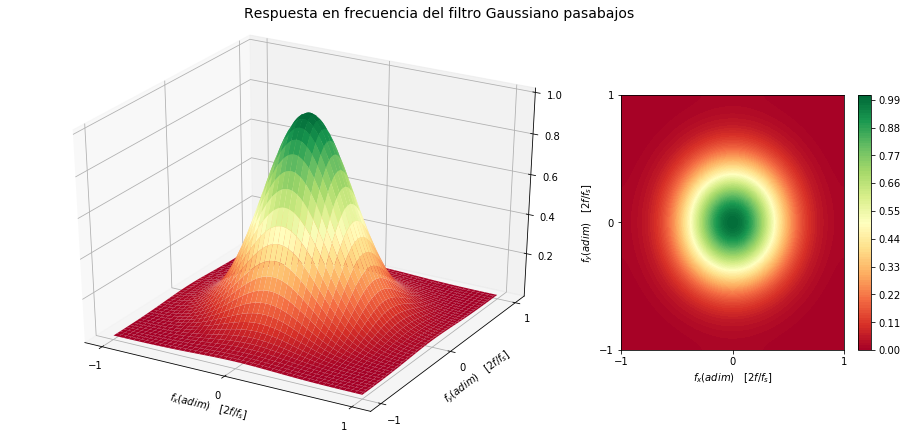

In [32]:
# Filtro Gaussiano...
L =  31 # dimensión del filtro
L_ = L//2
de = 1
x, y = np.meshgrid(np.arange(-L_,L_+1), np.arange(-L_,L_+1))
GLPF_s = st.multivariate_normal(mean=[0,0], cov=de).pdf(np.dstack((x, y)))

# Obtengo rta en frecuencia..
GLPF_f = rta_frec(GLPF_s, img)

# Visualizo..
visualizar_filtro(abs(GLPF_f), 'Gaussiano pasabajos')

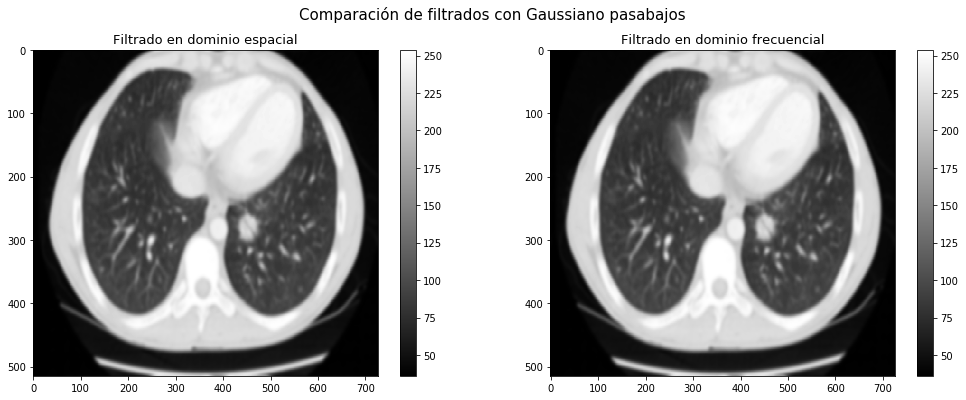

In [28]:
# Aplico filtrado en dominio espacial (CONVOLUCIÓN)
img_glp = si.convolve(img.astype(np.float64), GLPF_s, mode='wrap')
#img_glp = si.gaussian_filter(img.astype(np.float64), sigma=de**(1/2), mode='wrap')

# Aplico filtrado en dominio frecuencial (PRODUCTO)
img_glp2 = F*GLPF_f
img_glp2 = fft.ifft2(fft.ifftshift(img_glp2)).real

visualizar_filtrados([img_glp, img_glp2], tit='Comparación de filtrados con Gaussiano pasabajos')

***Verificando numéricamente...***

In [25]:
print('Salvo por diferencias numéricas, las imágenes son iguales: {}.\n(diferencia máxima: {:.2e})'
      .format(np.allclose(img_glp, img_glp2, atol=1e-3), abs(img_glp - img_glp2).max()))

Salvo por diferencias numéricas, las imágenes son iguales: True.
(diferencia máxima: 1.11e-12)


***
***Finalmente, para este último caso hacemos también la misma comparación pero usando -consistentemente- la otra "modalidad":
<br>- En espacio: convolución con padding 0 (y no convolución circular).
<br>- En frecuencia: producto con un filtro resultado de una transformación con padding previo en dominio espacial (G.Woods, 4.7).***

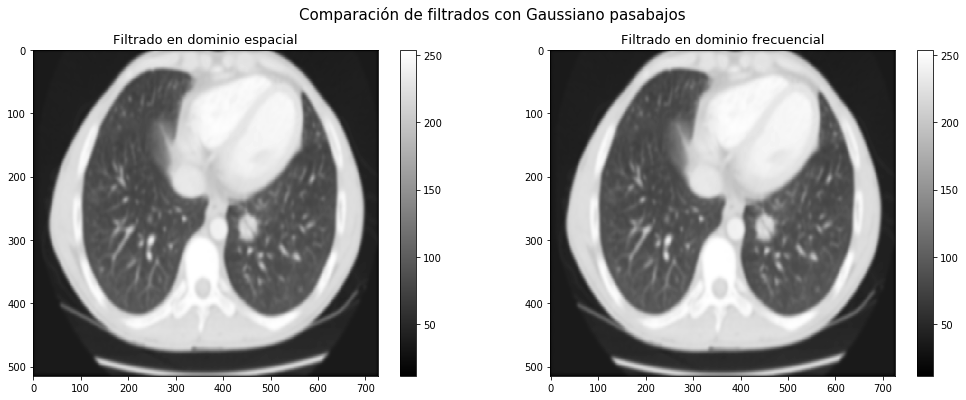

In [114]:
# FILTRADO EN DOMINIO ESPACIAL: CONVOLUCIÓN (ahora con padding 0)
img_glp_ = si.convolve(img.astype(np.float64), GLPF_s, mode='constant', cval=0)
#img_glp = si.gaussian_filter(img.astype(np.float64), sigma=de**(1/2), mode='constant', cval=0)


# FILTRADO EN DOMINIO FRECUENCIAL..
# Armo el filtro de forma adecuada para esta modalidad...             
img_ = np.pad(img, ((0, M-1), (0, N-1)), 'constant')     # pad de imagen                             
F_ = mi_fft(img_)                                              # transformo y centro
#F_ = fft.fft2(fft.fftshift(img_))
GLPF_f_ = rta_frec(GLPF_s, img_)                               # transformo filtro con dim acorde a imagen padded
                                                            
# Aplico filtrado con PRODUCTO..
img_glp2_ = F_*GLPF_f_                                         # producto en frecuencia
img_glp2_ = fft.ifft2(fft.ifftshift(img_glp2_)).real           # descentro, antitransformo y tomo parte real

# Extraigo cuadrante superior izquierdo..
img_glp2_ = img_glp2_[0:M, 0:N]


# VISUALIZO
visualizar_filtrados([img_glp_, img_glp2_], tit='Comparación de filtrados con Gaussiano pasabajos')

***Verifico que ambos filtrados son iguales...*** 

In [115]:
print('Salvo por diferencias numéricas, las imágenes son iguales: {}.\n(diferencia máxima: {:.2e})\n'
      .format(np.allclose(img_glp_, img_glp2_), abs(img_glp_ - img_glp2_).max()))

Salvo por diferencias numéricas, las imágenes son iguales: True.
(diferencia máxima: 1.19e-12)



***
***
<h1 style="color:green;font-size:50px;"><center>FIN!</center></h1>

***
***
***